In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [22]:
import jax
import jax.numpy as jnp
import treex as tx
from einops import rearrange
from flax import linen as nn
from abc import ABC, abstractmethod
from typing import *
from dataclasses import dataclass
import optax
import numpy as np
import matplotlib.pyplot as plt
import jax.tree_util as jtu
from hamux.utils import pytree_load, pytree_save

# HAM Energy Assembly

# Lagrangians

Because lagrangian functions of common activation functions can be used in both layers and synapses, it is helpful to define the operations outside the classes in which they operate.

In [5]:
def LIdentity(x):
    return 1/2 * jnp.power(x, 2).sum()

def LRelu(x):
    return 1/2 * jnp.power(jnp.maximum(x, 0), 2).sum()

def LSoftmax(x, beta=1., axis=-1):
    return 1/beta * jax.nn.logsumexp(beta * x, axis=axis)

## Layers

In [6]:
class Layer(tx.Module, ABC):
    shape: Tuple
    
    def __init__(self, shape):
        self.shape = shape
        
    @abstractmethod
    def lagrangian(self, x):
        pass
    
    def activation(self, x):
        return self.g(x)
    
    def energy(self, x):
        
        # When jitted, this is no slower than the optimized `@` vector multiplication
        # This is also more universal in case `x` is not a vector
        return jnp.multiply(self.g(x), x).sum() - self.lagrangian(x) 
    
    def g(self, x):
        return jax.grad(self.lagrangian)(x)
    
    def init_state(self, bs:int=None):
        if bs is not None:
            return jnp.zeros((bs, *self.shape))
        return jnp.zeros(self.shape)
    
class IdentityLayer(Layer):
    def lagrangian(self, x):
        return LIdentity(x)
    
class RELULayer(Layer):
    def lagrangian(self, x):
        return LRelu(x)
    
class SoftmaxLayer(Layer):
    beta: jnp.ndarray = tx.Parameter.node(default=jnp.array(1.))
    
    def lagrangian(self, x):
        return LSoftmax(x, self.beta.clip(1e-6))

In [7]:
layer = IdentityLayer((9,))
x = jnp.arange(9, dtype=jnp.float32)
print(f"Identity: {layer.g(x)}")

layer = RELULayer((9,))
x = jnp.arange(9, dtype=jnp.float32) - 5
print(f"RELU: {layer.g(x)})")

layer = SoftmaxLayer((9,))
x = jnp.arange(9, dtype=jnp.float32) - 2
print(f"Softmax: {layer.g(x)})")

Identity: [0. 1. 2. 3. 4. 5. 6. 7. 8.]
RELU: [0. 0. 0. 0. 0. 0. 1. 2. 3.])
Softmax: [2.1207899e-04 5.7649048e-04 1.5670636e-03 4.2597204e-03 1.1579121e-02
 3.1475313e-02 8.5558772e-02 2.3257288e-01 6.3219857e-01])


## Synapses

In [8]:
class Synapse(tx.Module, ABC):
    @abstractmethod
    def energy(self, *gs):
        pass
    
    def __call__(self, *gs):
        return self.energy(*gs)

class DenseSynapse(Synapse):
    stdinit:float = 0.02
    weight: jnp.ndarray = tx.Parameter.node()
        
    def energy(self, g1, g2):
        if self.initializing():
            key = tx.next_key() 
            self.weight = nn.initializers.normal(self.stdinit)(key, (g1.shape[0], g2.shape[0]))
        return -g1 @ self.weight @ g2
    

In [9]:
fin, fout = 44, 33
g1 = jnp.arange(fin)
g2 = jnp.ones(fout)
synapse = DenseSynapse().init(key=jax.random.PRNGKey(5), inputs=(g1, g2))
synapse.energy(g1, g2)

DeviceArray(-15.429065, dtype=float32)

## HAM

In [10]:
class HAM(tx.Module):
    layers: List[Layer]
    synapses: List[Synapse]
    connections: List[Tuple[Tuple, int]]

    def __init__(self, layers, synapses, connections):
        self.layers = layers
        self.synapses = synapses
        self.connections = connections
    
    @property
    def n_layers(self):
        return len(self.layers)
    
    @property
    def n_synapses(self):
        return len(self.synapses)
    
    @property
    def n_connections(self):
        return len(self.connections)
    
    def layer_energy(self, states):
        energies = jnp.stack([
            self.layers[i].energy(x) for i, x in enumerate(states)
        ])
        return jnp.sum(energies)
    
    def synapse_energy(self, states):
        def get_energy(lset, k):
            gs = [self.layers[i].g(states[i]) for i in lset]
            synapse = self.synapses[k]
            return synapse(*gs)

        energies = jnp.stack([
            get_energy(lset, k) for lset,k in self.connections
        ])
        return jnp.sum(energies)
    
    def energy(self, states):
        energy = self.layer_energy(states) + self.synapse_energy(states)
        return energy
    
    def venergy(self, states):
        return jax.vmap(self.energy, in_axes=self._statelist_batch_axes())(states)
    
    def __call__(self, states):
        return self.energy(states)
    
    def grad(self, states):
        return jax.grad(self.energy)(states)
    
    def vgrad(self, states):
        return jax.vmap(self.grad, in_axes=self._statelist_batch_axes())(states)
    
    def _statelist_batch_axes(self):
        return ([0 for _ in range(self.n_layers)],)
    
    def init_states(self, bs=None):
        return [layer.init_state(bs) for layer in self.layers]
    
    def init_states_and_params(self, key, bs=None):
        # params don't need a batch size to initialize
        params = self.init(key, self.init_states(), call_method="energy")
        states = self.init_states(bs)
        return states, params
    
    @classmethod
    def load_from_state_dict(cls, outdict):
        me = cls(outdict["layers"], outdict["synapses"], outdict["connections"])
        return me

# Dataloaders

# Loading from lib

In [5]:
from hamux.datasets import *

/home/hoo/miniconda3/envs/hamux/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
args = DataloadingArgs(
    dataset="torch/MNIST",
    aa=None,
    reprob=0.0,
    vflip=0.,
    hflip=0.,
    scale=(0.8,1.),
    batch_size=10,
    color_jitter=0.,
    validation_batch_size=10_000,
)
data_config = DataConfigMNIST(input_size=(1,28,28))

In [7]:
loader_train, loader_eval = create_dataloaders(args, data_config)

In [8]:
for b in loader_train:
    imgs, labels = b
    break

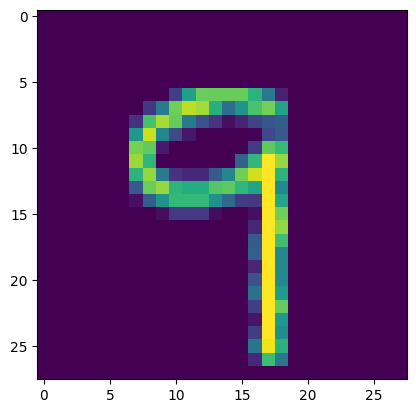

In [20]:
plt.imshow(data_config.show(imgs[7]))

# Example target pipeline

In [15]:
# All non-visible layers are encoded in a relationship
class HiddenRelationship(Synapse):
    """Combine my labels and pixels in the case of MNIST"""
    W1: jnp.ndarray = tx.Parameter.node()
    W2: jnp.ndarray = tx.Parameter.node()
    
    def __init__(self, nhid:int, stdinit:float = 0.02):
        self.nhid = nhid
        self.stdinit = 0.02

    def energy(self, g1, g2):
        if self.initializing():
            key = tx.next_key() 
            self.W1 = nn.initializers.normal(self.stdinit)(key, (g1.shape[0], self.nhid))
            self.W2 = nn.initializers.normal(self.stdinit)(key, (g2.shape[0], self.nhid))
        return LRelu(g1 @ self.W1 + g2 @ self.W2)
        

init_key = jax.random.PRNGKey(0)

layers = [
    IdentityLayer((784,)),
    IdentityLayer((10,)),
]
synapses = [
    HiddenRelationship(200),
]

connections = [
    ((0,1), 0),
]

bs = 5
states, ham = HAM(layers, synapses, connections).init_states_and_params(jax.random.PRNGKey(0), bs=bs)

@jax.jit
def forward_classification_mnist(model, x):
    depth = 1
    alpha = 0.1
    
    bs = x.shape[0]
    xs = model.init_states(bs)
    xs[0] = jnp.array(x)
    for i in range(depth):
        updates = model.vgrad(xs)
        xs = jtu.tree_map(lambda x, u: x - alpha * u, xs, updates)
    
    logits = xs[1]
    return logits

batch = {
    "images": jnp.array(b[0][:10]),
    "labels": jnp.array(b[1][:10])
}
x = rearrange(batch["images"], "bs ... -> bs (...)")

logits = forward_classification_mnist(ham, x)
print(logits.shape)
    

(10, 10)


# Training Logic

In [16]:
class TrainState(tx.Module):
    model: tx.Module
    optimizer: tx.Optimizer
    apply_fn: Callable
    
    def __init__(self, model, optimizer, apply_fn):
        self.model = model
        self.optimizer = tx.Optimizer(optimizer).init(self.params)
        self.apply_fn = apply_fn
        
    @property
    def params(self):
        return self.model.filter(tx.Parameter)
    
    def apply_updates(self, grads):
        new_params = self.optimizer.update(grads, self.params)
        self.model = self.model.merge(new_params)
        return self

In [17]:
def cross_entropy_loss(*, logits, labels):
    n_classes = logits.shape[-1]
    labels_onehot = jax.nn.one_hot(labels, num_classes=n_classes)
    return optax.softmax_cross_entropy(logits=logits, labels=labels_onehot).mean()

def compute_metrics(*, logits, labels):
    loss = cross_entropy_loss(logits=logits, labels=labels)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    metrics = {
      'loss': loss,
      'accuracy': accuracy,
    }
    return metrics

In [18]:
@jax.jit
def train_step(state, batch):
    def loss_fn(params):
        state.model = state.model.merge(params)
        x = rearrange(batch["image"], "bs ... -> bs (...)")
        logits = state.apply_fn(state.model, x)
        loss = cross_entropy_loss(logits=logits, labels=batch["label"])
        return loss, (logits, state)
        
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_, (logits, state)), grads = grad_fn(state.params)
    
    state = state.apply_updates(grads)
    metrics = compute_metrics(logits=logits, labels=batch['label'])
    return state, metrics

@jax.jit
def eval_step(state, batch):
    x = rearrange(batch["image"], "bs ... -> bs (...)")
    logits = state.apply_fn(state.model, x)
    logit_pred = jnp.argmax(logits, axis=-1)
    return compute_metrics(logits=logits, labels=batch['label'])

def train_epoch(state, train_dl, epoch):
    """Train for a single epoch."""
    batch_metrics = []
    bs = train_dl.batch_size
    for i, batch in enumerate(train_dl):
        if (i % 100) == 0:
            print("Starting example: ", i*bs)
        batch = {
            "image": jnp.array(batch[0]),
            "label": jnp.array(batch[1])
        }
        state, metrics = train_step(state, batch)
        batch_metrics.append(metrics)
            

    # compute mean of metrics across each batch in epoch.
    batch_metrics_np = jax.device_get(batch_metrics)
    epoch_metrics_np = {
      k: np.mean([metrics[k] for metrics in batch_metrics_np])
      for k in batch_metrics_np[0]}

    print('train epoch: %d, loss: %.4f, accuracy: %.2f' % (
      epoch, epoch_metrics_np['loss'], epoch_metrics_np['accuracy'] * 100))

    return state, epoch_metrics_np['loss'], epoch_metrics_np['accuracy'] * 100

def eval_model(params, test_dl):
    batch_metrics = []
    bs = test_dl.batch_size

    for i, batch in enumerate(test_dl):
        if (i % 1000) == 0:
                print("Starting example: ", i*bs)
        batch = {
            "image": jnp.array(batch[0]),
            "label": jnp.array(batch[1])
        }
        
        metrics = eval_step(params, batch)
        batch_metrics.append(metrics)
    batch_metrics_np = jax.device_get(batch_metrics)
    summary = {
      k: np.mean([metrics[k] for metrics in batch_metrics_np])
      for k in batch_metrics_np[0]
    }

    return summary['loss'], summary['accuracy']

## Convolutional MNIST

### Configuration

In [19]:
@jax.jit
def train_step(state, batch):
    def loss_fn(params):
        state.model = state.model.merge(params)
        x = batch["image"]
        logits = state.apply_fn(state.model, x)
        loss = cross_entropy_loss(logits=logits, labels=batch["label"])
        return loss, (logits, state)
        
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_, (logits, state)), grads = grad_fn(state.params)
    
    state = state.apply_updates(grads)
    metrics = compute_metrics(logits=logits, labels=batch['label'])
    return state, metrics

@jax.jit
def eval_step(state, batch):
    x = batch["image"]
    logits = state.apply_fn(state.model, x)
    logit_pred = jnp.argmax(logits, axis=-1)
    return compute_metrics(logits=logits, labels=batch['label'])

# # Example loading CIFAR. We need an "args" and a "data_config"
# args = DataloadingArgs(
#     dataset="torch/CIFAR10",
#     # aa="rand",
#     aa=None,
#     reprob=0.2,
#     vflip=0.2,
#     hflip=0.5,
#     batch_size=128,
#     validation_batch_size=10_000, # Get the entire validation set at once
# )
# data_config = DataConfigCIFAR10()

# ## Example loading ImageNet. We need an "args" and a "data_config"
# args = DataloadingArgs(
#     data_dir=Path.home()/"datasets/timm-datasets/ImageNet100",
#     aa=None,
#     reprob=0.1,
#     vflip=0.0,
#     hflip=0.5,
#     batch_size=256,
#     validation_batch_size=500
# )
# data_config = DataConfigImageNet(input_size=(3,128,128)) # Feel free to change the input size of our dataset!

## Example loading MNIST
args = DataloadingArgs(
    dataset="torch/MNIST",
    aa=None,
    reprob=0.0,
    vflip=0.,
    hflip=0.,
    scale=(0.8,1.),
    batch_size=2000,
    color_jitter=0.,
    validation_batch_size=10_000,
)
data_config = DataConfigMNIST(input_size=(1,28,28))

train_dl, eval_dl = create_dataloaders(args, data_config)

In [20]:
# All non-visible layers are encoded in a relationship
class HiddenRelationship(Synapse):
    """Combine my labels and pixels in the case of MNIST"""
    W1: jnp.ndarray = tx.Parameter.node()
    W2: jnp.ndarray = tx.Parameter.node()
    
    def __init__(self, nhid:int, stdinit:float = 0.02):
        self.nhid = nhid
        self.stdinit = 0.02

    def energy(self, g1, g2):
        if self.initializing():
            key = tx.next_key() 
            self.W1 = nn.initializers.normal(self.stdinit)(key, (g1.shape[0], self.nhid))
            self.W2 = nn.initializers.normal(self.stdinit)(key, (g2.shape[0], self.nhid))
        return LRelu(g1 @ self.W1 + g2 @ self.W2)


class ConvSynapse(Synapse):
    conv: tx.Module    
    
    def __init__(self, conv:tx.Module):
        self.conv = conv

    def energy(self, g1, g2):
        if self.initializing():
            key = tx.next_key()
            features_in = g1.shape[0]
            features_out = g2.shape[0]
            self.conv = self.conv.init(key, g1)
        return jnp.multiply(g2, self.conv(g1)).sum()
        
init_key = jax.random.PRNGKey(0)

# layers = [
#     IdentityLayer((1,28,28)),
#     ReluLayer(),
#     IdentityLayer((10,)),
# ]
# synapses = [
#     HiddenRelationship(200),
# ]

# connections = [
#     ((0,1), 0),
# ]


# @jax.jit
# def forward_classification_mnist(model, x):
#     depth = 4
#     alpha = 1.
    
#     bs = x.shape[0]
#     xs = model.init_states(bs)
#     masks = jtu.tree_map(lambda x: jnp.ones_like(x, dtype=jnp.int8), xs)
#     xs[0] = jnp.array(x)
#     masks[0] = jnp.zeros_like(masks[0], dtype=jnp.int8)

#     for i in range(depth):
#         updates = model.vgrad(xs)
#         xs = jtu.tree_map(lambda x, u, m: x - alpha * u * m, xs, updates, masks)
    
#     logits = xs[1]
#     return logits


# bs = 1
# states, ham = HAM(layers, synapses, connections).init_states_and_params(jax.random.PRNGKey(0), bs=bs)

# optimizer = optax.adamw(0.001)
# state = TrainState(ham, optimizer, forward_classification_mnist)

### Training Cell

In [21]:
# num_epochs = 100
# train_acc_list=[]
# test_acc_list=[]

# for epoch in range(1, num_epochs + 1):
#     # Use a separate PRNG key to permute image data during shuffling
#     state, train_loss, train_acc = train_epoch(state, train_dl, epoch)

#     # Evaluate on the test set after each training epoch 
#     test_loss, test_acc = eval_model(state, eval_dl)
#     train_acc_list.append(train_acc)
#     test_acc_list.append(100*test_acc)
#     print(f"Max acc test: {np.max(test_acc_list)}")
#     print(f"Acc epoch {epoch} [train/tst]: [{train_acc}/{test_acc}]")
    

## Vectorized MNIST

### Configuration

In [22]:

# # Example loading CIFAR. We need an "args" and a "data_config"
# args = DataloadingArgs(
#     dataset="torch/CIFAR10",
#     # aa="rand",
#     aa=None,
#     reprob=0.2,
#     vflip=0.2,
#     hflip=0.5,
#     batch_size=128,
#     validation_batch_size=10_000, # Get the entire validation set at once
# )
# data_config = DataConfigCIFAR10()

# ## Example loading ImageNet. We need an "args" and a "data_config"
# args = DataloadingArgs(
#     data_dir=Path.home()/"datasets/timm-datasets/ImageNet100",
#     aa=None,
#     reprob=0.1,
#     vflip=0.0,
#     hflip=0.5,
#     batch_size=256,
#     validation_batch_size=500
# )
# data_config = DataConfigImageNet(input_size=(3,128,128)) # Feel free to change the input size of our dataset!

## Example loading MNIST
args = DataloadingArgs(
    dataset="torch/MNIST",
    aa=None,
    reprob=0.1,
    vflip=0.,
    hflip=0.,
    scale=(0.7,1.),
    batch_size=100,
    # batch_size=2000,
    color_jitter=0.4,
    validation_batch_size=1000,
)
data_config = DataConfigMNIST(input_size=(1,28,28))

train_dl, eval_dl = create_dataloaders(args, data_config)

In [25]:
# All non-visible layers are encoded in a relationship
class HiddenRelationship(Synapse):
    """Combine my labels and pixels in the case of MNIST"""
    W1: jnp.ndarray = tx.Parameter.node()
    W2: jnp.ndarray = tx.Parameter.node()
    beta: jnp.ndarray = tx.Parameter.node()
    
    def __init__(self, nhid:int, stdinit:float = 0.02, beta_init=1.):
        self.nhid = nhid
        self.stdinit = 0.02
        self.beta = jnp.array(beta_init)

    def energy(self, g1, g2):
        if self.initializing():
            key = tx.next_key() 
            self.W1 = nn.initializers.normal(self.stdinit)(key, (g1.shape[0], self.nhid))
            self.W2 = nn.initializers.normal(self.stdinit)(key, (g2.shape[0], self.nhid))
        # return LSoftmax(g1 @ self.W1 + g2 @ self.W2, self.beta.clip(1e-6))
        return LRelu(g1 @ self.W1 + g2 @ self.W2)

    
## This wasn't particularly useful
# class Hidden2LayerRelationship(Synapse):
#     """Combine my labels and pixels in the case of MNIST"""
#     W1: jnp.ndarray = tx.Parameter.node()
#     W2: jnp.ndarray = tx.Parameter.node()
#     W3: jnp.ndarray = tx.Parameter.node()
    
#     def __init__(self, nhid:int, stdinit:float = 0.02):
#         self.nhid = nhid
#         self.stdinit = 0.02

#     def energy(self, g1, g2):
#         if self.initializing():
#             key = tx.next_key() 
#             self.W1 = nn.initializers.normal(self.stdinit)(key, (g1.shape[0], self.nhid))
#             self.W2 = nn.initializers.normal(self.stdinit)(key, (g2.shape[0], self.nhid))
#             self.W3 = nn.initializers.normal(self.stdinit)(key, (self.nhid, self.nhid))
#         x = g1 @ self.W1 + g2 @ self.W2
#         return LRelu(x)
#         # x = jax.nn.tanh(g1 @ self.W1 + g2 @ self.W2)
#         # return LRelu(x @ self.W3)
        
        
init_key = jax.random.PRNGKey(0)

layers = [
    IdentityLayer((784,)),
    IdentityLayer((10,)),
]
synapses = [
    HiddenRelationship(30),
]

connections = [
    ((0,1), 0),
]


@jax.jit
def forward_classification_mnist(model, x):
    depth = 4
    alpha = 1.
    
    bs = x.shape[0]
    x = rearrange(x, "... h w -> ... (h w)")
    xs = model.init_states(bs)
    masks = jtu.tree_map(lambda x: jnp.ones_like(x, dtype=jnp.int8), xs)
    xs[0] = jnp.array(x)
    masks[0] = jnp.zeros_like(masks[0], dtype=jnp.int8)

    for i in range(depth):
        updates = model.vgrad(xs)
        xs = jtu.tree_map(lambda x, u, m: x - alpha * u * m, xs, updates, masks)
    
    logits = xs[1]
    return logits


bs = 1
states, ham = HAM(layers, synapses, connections).init_states_and_params(jax.random.PRNGKey(0), bs=bs)

optimizer = optax.adamw(0.001)
state = TrainState(ham, optimizer, forward_classification_mnist)

### Training Cell

In [26]:
num_epochs = 100
train_acc_list=[]
test_acc_list=[]

for epoch in range(1, num_epochs + 1):
    # Use a separate PRNG key to permute image data during shuffling
    state, train_loss, train_acc = train_epoch(state, train_dl, epoch)

    # Evaluate on the test set after each training epoch 
    test_loss, test_acc = eval_model(state, eval_dl)
    train_acc_list.append(train_acc)
    test_acc_list.append(100*test_acc)
    print(f"Max acc test: {np.max(test_acc_list)}")
    print(f"Acc epoch {epoch} [train/tst]: [{train_acc}/{test_acc}]")
    

RuntimeError: DataLoader worker (pid(s) 2397599, 2397635, 2397671, 2397707) exited unexpectedly

In [ ]:
# pytree_save(ham.to_dict(), "./mnist_model")
# outmodel = pytree_load("./mnist_model.pckl")

In [ ]:
# pytree_save(ham, "./mnist_model_ham")

## Quick interpretation

In [ ]:
def forward_interpretability(model:tx.Module, logit_state:jnp.ndarray):
    depth = 12
    alpha = 1.
    
    
    xs = model.init_states()
    xs_list = np.empty((depth, xs[0].shape[0]))

    assert logit_state.shape == xs[1].shape
    xs[1] = logit_state
    masks = jtu.tree_map(lambda x: jnp.ones_like(x, dtype=jnp.int8), xs)
    masks[1] = jnp.zeros_like(masks[1], dtype=jnp.int8)
    
    mgrad = jax.jit(model.grad)
    
    @jax.jit
    def step(model, xs):
        updates = model.grad(xs)
        xs = jtu.tree_map(lambda x, u, m: x - alpha * u * m, xs, updates, masks)
        return xs

    for i in range(depth):
        xs = step(model, xs)
        xs_list[i] = xs[0]
    
    # Return the pixels, vectorized
    return xs_list

In [ ]:
frz_logits = jnp.zeros(10, dtype=jnp.float32).at[0].set(50)
xs_list = forward_interpretability(ham, frz_logits)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def restore_mnist_imgs(x):
    return rearrange(x, "... (h w) -> ... h w", h=28, w=28)

In [ ]:
trajectory = restore_mnist_imgs(xs_list) + 0.5

In [ ]:
plt.imshow(trajectory[-1])

So that trajectory isn't displaying what I want it to. What is the issue?

Visualize the weights?

In [ ]:
immems = ham.synapses[0].W1

In [ ]:
mems = restore_mnist_imgs(immems.T)

In [ ]:
plt.imshow(mems[40])